# PLN - Pré-processamento de texto
Neste *notebook*, há diversas etapas utilizadas no pré-processamento do *corpus* DepreRedditBR. Para saber mais sobre as referências utilizadas no desenvolvimento deste fluxo, veja o arquivo `README.md`.

In [21]:
import pandas as pd

# Importar o corpus de um arquivo CSV
df = pd.read_csv('data/DepreRedditBR.csv')

# Flag utilizada para definir se a ferramenta Enelvo será utilizada ou não
USE_ENELVO = False
APPLY_LEMMATIZATION = False

# Obter o tamanho do dataset (linhas x colunas)
df.shape

(509669, 1)

## Exibir o dataframe

In [22]:
df.head() # Exibir as primeiras linhas do dataframe

,text
0,"Parece que ninguem quer ficar perto de mim, e,..."
1,"Eu sou deprimido, porem tem períodos que fico ..."
2,"Boa tarde. Bem, é basicamente um desabafo. A v..."
3,"Me tirem uma duvida, ser perfeccionista ao ac..."
4,"Oi gente, desculpa o textão, já mandei isso em..."


In [23]:
# Obter uma amostra do corpus (frac -> de 0 a 1)
df = df.sample(frac=0.01, random_state=42)

# Utilizando uma amostra pequena para testes
# df = df.sample(n=500, random_state=42)

# Obter a única coluna do dataframe: text
all_texts = df.text

Exibindo o conjunto de dados após a extração da única coluna em uma variável do tipo `pd.Series`.

In [24]:
all_texts

208601    não há nada que eu queira mais do que voltar n...
462528    Lidando com mudanças de humor Tenho tido muita...
76680     Se sua noiva não usar com voce, ja sabe. Não p...
359032    muitas vezes não consigo trabalhar cerca de um...
353889    quais são suas ações quando você está se senti...
                                ...                        
71960     Faz uma mistura de lidocaína e lubrificante me...
426392    tentando aconselhar um amigo próximo com doenç...
270923    não sei mais o que fazer, não sei mais o que f...
55606                           sim, vou pegar as inimigas?
505022    Tentei usar a música como uma forma de express...
Name: text, Length: 5097, dtype: object

## Opcional - Utilizano o Enelvo para normalizar aspectos do corpus
A normalização com Enelvo trata de aspectos como erros ortográficos, gírias, siglas e outros detalhes. A substituição das virgulas por uma *label* temporária é feita para contornar a ferramenta Enelvo, que separa números com vírgula durante a normalização.

Para este caso, utilizar o Enelvo demanda uma considerável quantidade de tempo, dado que os textos são densos e há uma grande quantidade de textos no *corpus* utilizado. Dessa maneira, utilizar-se-á apenas uma pequena amostra do conjunto de dados.

In [25]:
# Enelvo (https://thalesbertaglia.com/enelvo/)
from enelvo.normaliser import Normaliser

def replace_commas(texts: pd.Series) -> pd.Series:
    return texts.str.replace(r',', 'chavevirg')

def revert_replace_commas(texts: pd.Series) -> pd.Series:
    return texts.str.replace('chavevirg', ',')

def apply_enelvo_normalise(
        texts: pd.Series,
        normaliser_instance: Normaliser) -> pd.Series:
    return texts.apply(lambda text: normaliser_instance.normalise(text))

if USE_ENELVO:
    # Obter uma pequena amostra do corpus
    all_texts = all_texts.sample(n=20, random_state=1)
    print(f"\n----- TEXTOS ANTES DA NORMALIZAÇÃO -----\n\n{all_texts.values}")

    # Substituir as vírgulas pela label 'chavevirg' para evitar conflitos durante a normalização do texto
    all_texts = replace_commas(all_texts)

    # Aplicar a normalização com Enelvo para os textos do corpus
    all_texts = apply_enelvo_normalise(
        all_texts,
        Normaliser(tokenizer='readable')
    )

    print(f"\n----- TEXTOS DEPOIS DA NORMALIZAÇÃO -----\n\n{all_texts.values}")

## Remoção de URLs
A remoção de URLs é uma etapa importante para reduzir o ruído do conjunto de dados e manter apenas palavras relevantes para o treinamento do modelo.

In [26]:
import re
# Remove URLs if there is any
all_texts = all_texts.apply(lambda text: re.sub(r'http\S+', '', text))

if USE_ENELVO:
    # Reverter a substituição de vírgulas
    all_texts = revert_replace_commas(all_texts)

all_texts

208601    não há nada que eu queira mais do que voltar n...
462528    Lidando com mudanças de humor Tenho tido muita...
76680     Se sua noiva não usar com voce, ja sabe. Não p...
359032    muitas vezes não consigo trabalhar cerca de um...
353889    quais são suas ações quando você está se senti...
                                ...                        
71960     Faz uma mistura de lidocaína e lubrificante me...
426392    tentando aconselhar um amigo próximo com doenç...
270923    não sei mais o que fazer, não sei mais o que f...
55606                           sim, vou pegar as inimigas?
505022    Tentei usar a música como uma forma de express...
Name: text, Length: 5097, dtype: object

## Remoção de pontuação
A remoção de pontuação visa a redução do ruído (mantendo apenas as palavras que importam) e aumenta a eficiência do processamento.
É importante frisar que a pontuação **NÃO** é removida quando faz parte de *hashtags*, datas ou números com vírgula.

In [27]:
def remove_punctuation(text: str):
    return re.sub(
        r'(?<!\d),(?=\D)|(?<=\D),(?!\d)|(?<!\d),(?=\d)|(?<!\d)\/|\/(?!\d)|_|[^\w#\/\s,\@]','', text)

all_texts = all_texts.apply(lambda text: remove_punctuation(text))
all_texts.values

array(['não há nada que eu queira mais do que voltar no tempo e refazer minha vida com todas as memórias e conhecimentos que tenho agora eu sonho acordado com isso constantemente é a única coisa que me dá uma aparência de felicidade Na verdade eu era feliz quando criança tenho boas lembranças de brincar com meus amigos desenhar assistir desenhos animados etc e parte meu coração saber que nunca mais serei feliz de verdade assim se eu tivesse que adivinhar onde tudo deu errado provavelmente foi quando fui separado de meus amigos no ensino fundamental Desenvolvi ansiedade geralsocial e depressão se eu pudesse retroceder minha vida não deixaria que isso me afetasse tanto faria novos bons amigos eu também levaria o desenho mais a sério queria trabalhar com animação mas minha anedonia tirou toda a minha motivação Além disso fico muito desanimado quando vejo alguém que é muito melhor do que eu Eu também leria mais livros assistiria mais filmesprogramas etc eu sei que poderia fazer isso agora 

## Tokenização do texto
Após a remoção de partes menos relevantes dos textos pertencentes ao *corpus*, é importante tokenizá-los, permitindo a aplicação de diversas técnicas, a exemplo da contagem de vocabulário. Além disso, facilita-se o processamento computacional do *corpus*.

In [28]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
all_texts = all_texts.apply(lambda text: word_tokenize(text.lower()))
all_texts

[nltk_data] Downloading package punkt_tab to /home/yago/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


208601    [não, há, nada, que, eu, queira, mais, do, que...
462528    [lidando, com, mudanças, de, humor, tenho, tid...
76680     [se, sua, noiva, não, usar, com, voce, ja, sab...
359032    [muitas, vezes, não, consigo, trabalhar, cerca...
353889    [quais, são, suas, ações, quando, você, está, ...
                                ...                        
71960     [faz, uma, mistura, de, lidocaína, e, lubrific...
426392    [tentando, aconselhar, um, amigo, próximo, com...
270923    [não, sei, mais, o, que, fazer, não, sei, mais...
55606                       [sim, vou, pegar, as, inimigas]
505022    [tentei, usar, a, música, como, uma, forma, de...
Name: text, Length: 5097, dtype: object

## Remoção de *stopwords*
É necessário remover palavras muito comuns no idioma, visto que, geralmente, elas trazem pouco significado semântico. Isso ajuda a **reduzir a dimensionalidade** e a aumentar a ênfase do vocabulário em **palavras mais importantes**.

Exemplos: artigos, preposições, conjunções, pronomes, advérbios de frequência e modo etc.

In [29]:
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(text: str):
    # Manter apenas as palavras que não esteja na lista de stopwords em Português
    words = [w for w in text if w not in stopwords.words('portuguese')]
    return words

all_texts = all_texts.apply(lambda text: remove_stopwords(text))
all_texts.head(10)

[nltk_data] Downloading package stopwords to /home/yago/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


208601    [nada, queira, voltar, tempo, refazer, vida, t...
462528    [lidando, mudanças, humor, tido, muitas, mudan...
76680     [noiva, usar, voce, ja, sabe, pergunte, nao, f...
359032    [muitas, vezes, consigo, trabalhar, cerca, hor...
353889    [quais, ações, sentindo, ansioso, procurando, ...
109915    [mano, difícil, ainda, traumas, questão, fez, ...
227263    [sei, quero, então, hoje, chamado, conselheiro...
360618    [pai, culpando, bater, poste, vez, ajudar, des...
325730    [alguém, estala, dedos, vezes, repetidamente, ...
282442    [deprimido, tido, crises, longo, meses, vezes,...
Name: text, dtype: object

## Lematização
Aplicar a lematização neste *corpus* é interessante para a redução do vocabulário, tendo em vista o grande número de palavras presentes no texto. Apesar disso, o tempo necessário para realizar esse processamento também é elevado, visto que é um processo complexo.

In [30]:
import spacy
import spacy.cli

spacy.cli.download('pt_core_news_sm')
nlp = spacy.load('pt_core_news_sm')

def lemmatize_text(texts: pd.Series):
    docs = [nlp(text) for text in texts]
    lemmas = [token.lemma_ for doc in docs for token in doc]
    return lemmas

if APPLY_LEMMATIZATION:                                 
    all_texts = all_texts.apply(lemmatize_text)
    print(f"\n----- TEXTOS LEMATIZADOS -----\n\n{all_texts.values}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 30.8 MB/s eta 0:00:00m eta 0:00:010:0101
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Extração de *insights* a partir do *corpus*
Após as etapas de pré-processamento anteriormente aplicadas, é possível obter *insights* valiosos sobre o *corpus*.

In [31]:
# Obter a quantidade total de palavras para o corpus
def get_total_word_count(texts: pd.Series) -> int:
    total_word_count = 0
    for text in texts:
        total_word_count += len(text)
    return total_word_count

### Quantidade média de palavras por texto

In [32]:
avg_word_count = get_total_word_count(all_texts) / all_texts.shape[0]
print(f'Quantidade média de palavras por texto (aproximação): {round(avg_word_count)}')

Quantidade média de palavras por texto (aproximação): 68


### Nuvem de palavras

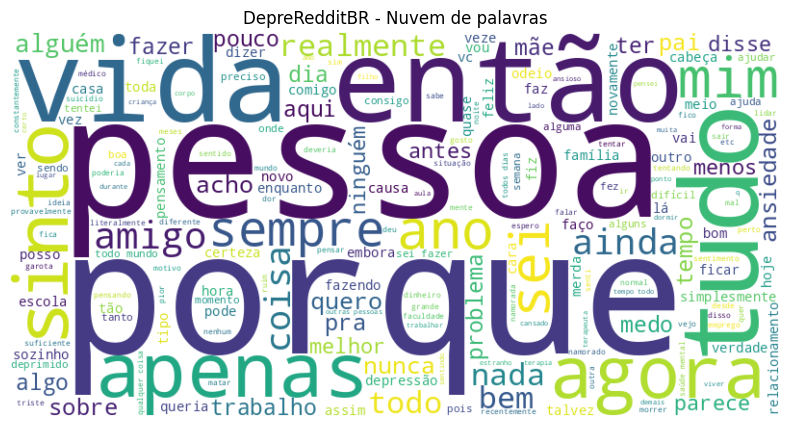

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Juntar as linhas tokenizadas em uma só string
joined_rows = all_texts.apply(lambda text: ' '.join(text))
# Juntar todos os textos em uma string
all_texts_joined = ' '.join(text for text in joined_rows)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_texts_joined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('DepreRedditBR - Nuvem de palavras')
plt.show()

### Distribuição de frequência das palavras mais comuns

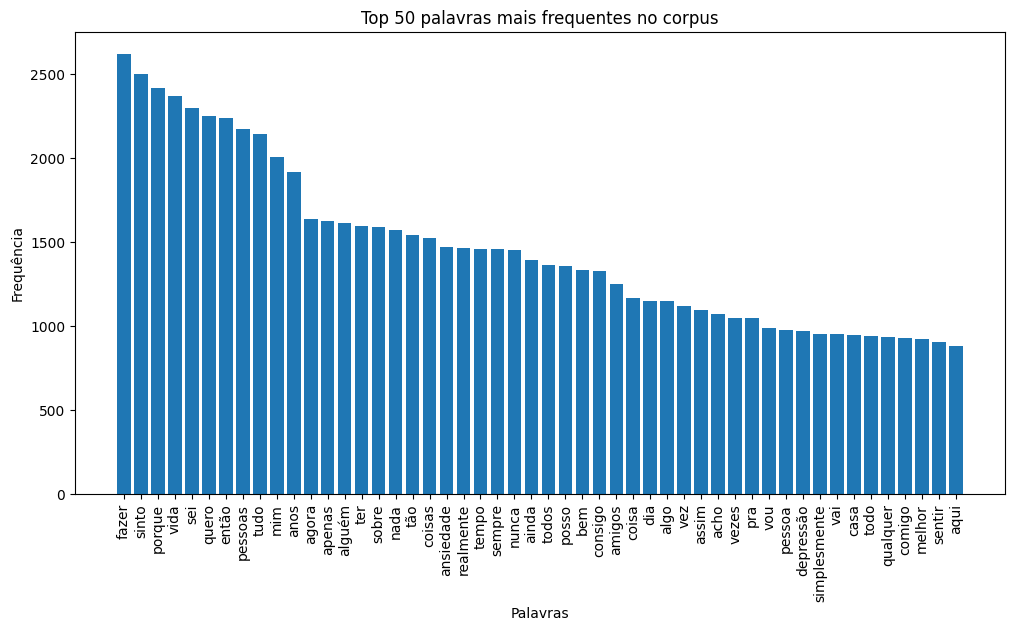

In [38]:
from collections import Counter

# Unindo todas as listas de tokens em uma única lista
all_tokens = [token for tokens in all_texts for token in tokens]

freq_dist = Counter(all_tokens)

# Selecionar as top N palavras mais comuns
top_n = 50
most_common = freq_dist.most_common(top_n)

# Separar palavras e frequências
words, counts = zip(*most_common)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation='vertical')
plt.xlabel("Palavras")
plt.ylabel("Frequência")
plt.title(f"Top {top_n} palavras mais frequentes no corpus")
plt.show()